In [13]:
using Pkg

# Pkg.add("DataFrames")
# Pkg.add("DotEnv")
# Pkg.add("CSV")
# Pkg.add("Plots")
# Pkg.add("Dates")
# Pkg.add("Gadfly")
# Pkg.add("StatsPlots")
# Pkg.add("StatsBase")
# Pkg.add("JSON")
# Pkg.add("Makie")


# https://www.datacamp.com/blog/introduction-machine-learning-julia
#
# Importing and handling data: CSV, DataFrames
# Plotting and output: Plots, StatsPlots, LaTeXStrings, Measures, Makie
# Statistics and Math: Random, Statistics, LinearAlgebra, StatsBase, Distributions, HypothesisTests, KernelDensity, Lasso, Combinatorics, SpecialFunctions, Roots
# Individual machine learning packages:
#    - Generalized linear models (e.g. linear regression, logistic regression): GLM
#    - Deep Learning: Flux, Knet
#    - Support vector machines: LIBSVM
#    - Decision tree, random forest, AdaBoost: DecisionTree
#    - K-nearest neighbors: NearestNeighbors
#    - K-means clustering: Clustering
#    - Principal component analysis: MultivariateStats


#### Environment configuration

In [14]:
using DotEnv

DotEnv.config("../.path_env", true)
alarms_data_file_path = "../" * ENV["ALARMS_DATA_FILE"]
regions_data_file_path = "../" * ENV["REGIONS_DATA_FILE"]
weather_data_file_path = "../" * ENV["WEATHER_DATA_FILE"]
tfidf_csv_path = "../" * ENV["ISW_TF_IDF_RESULT"]

"../2_data_preparation/results/tfidf.csv"

### Alarms

In [15]:
using DataFrames
using CSV

alarms = DataFrame(CSV.File(alarms_data_file_path))

println(size(alarms))

eltype.(eachcol(alarms))

(19933, 9)


9-element Vector{DataType}:
 Int64
 Int64
 String
 String
 Int64
 String31
 String31
 String31
 String7

In [16]:
# first 10 rows of the alarms
first(alarms, 10)

Row,id,region_id,region_title,region_city,all_region,start,end,clean_end,intersection_alarm_id
,Int64,Int64,String,String,Int64,String31,String31,String31,String7
1,2,3,Вінниччина,Вінниця,0,2022-02-25 22:55:42,2022-02-25 23:41:53,2022-02-25 23:41:53,NULL
2,4,12,Львівщина,Львів,0,2022-02-26 06:26:17,2022-02-26 07:15:28,2022-02-26 07:15:28,NULL
3,5,14,Одещина,Одеса,0,2022-02-26 07:16:58,2022-02-26 07:47:03,2022-02-26 07:47:03,NULL
4,6,6,Житомирщина,Житомир,0,2022-02-26 08:05:54,2022-02-26 09:36:36,2022-02-26 09:36:36,NULL
5,7,3,Вінниччина,Вінниця,0,2022-02-26 08:39:39,2022-02-26 10:42:41,2022-02-26 10:42:41,NULL
6,9,3,Вінниччина,Вінниця,0,2022-02-26 10:58:23,2022-02-26 11:59:40,2022-02-26 11:59:40,NULL
7,10,12,Львівщина,Львів,0,2022-02-26 13:44:44,2022-02-26 14:27:25,2022-02-26 14:27:25,NULL
8,3,16,Рівненщина,Рівненська обл.,1,2022-02-26 15:54:53,2022-02-26 16:14:46,2022-02-26 16:14:46,NULL
9,1,2,Волинь,Волинська обл.,1,2022-02-26 16:08:26,2022-02-26 16:39:26,2022-02-26 16:39:26,NULL


In [17]:
# describe dataset
describe(alarms)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,id,19504.3,1,17421.0,47547,0,Int64
2,region_id,11.1598,1,10.0,24,0,Int64
3,region_title,,Івано-Франківщина,,️Донеччина,0,String
4,region_city,,Єланець,,Южноукраїнськ,0,String
5,all_region,0.696283,0,1.0,1,0,Int64
6,start,,2022-02-25 22:55:42,,2023-01-20 22:51:11,0,String31
7,end,,2022-02-25 23:41:53,,2023-01-20 23:22:34,0,String31
8,clean_end,,2022-02-25 23:41:53,,NULL,0,String31
9,intersection_alarm_id,,10134,,NULL,0,String7


In [18]:
# first event date
println("first event date: ", minimum(alarms[!, :start]))

# max event date
println("max event date: ", maximum(alarms[!, :end]))

first event date: 2022-02-25 22:55:42
max event date: 2023-01-20 23:22:34


In [19]:
using Dates
using Statistics

transform!(alarms, [:start, :end] => ((x, y) -> DateTime.(y, "yyyy-mm-dd HH:MM:SS") - DateTime.(x, "yyyy-mm-dd HH:MM:SS")) => :duration)

transform!(alarms, :duration => (x -> Minute.(round.(Int, Dates.value.(x) / (1000 * 60)))) => :duration)

println("minimum duration: ", minimum(alarms[!, :duration]))
println("maximum duration: ", maximum(alarms[!, :duration]))

sort!(alarms, :duration, rev=false)
println(first(alarms, 10))
sort!(alarms, :duration, rev=true)
println(first(alarms, 10))

minimum duration: 0 minutes
maximum duration: 1123 minutes
10×10 DataFrame
 Row │ id     region_id  region_title      region_city        all_region  start                end                  clean_end            intersection_alarm_id  duration  
     │ Int64  Int64      String            String             Int64       String31             String31             String31             String7                Minute    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 18171          9  Київщина          Київська обл.               1  2022-06-21 08:51:29  2022-06-21 08:51:56  2022-06-21 08:51:56  NULL                   0 minutes
   2 │    41         12  Львівщина         Трускавець                  0  2022-02-27 19:51:41  2022-02-27 19:52:49  2022-02-27 19:52:49  NULL                   1 minute
   3 │   585         13  Миколаївщина      Первомайськ                 0 

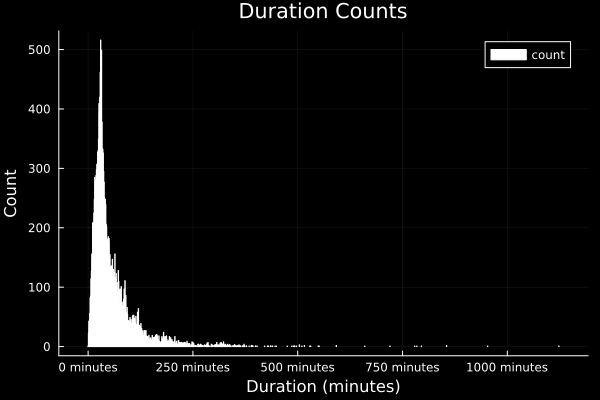

In [20]:
# visualize duration and corresponding counts using StatsPlots
using StatsPlots
using StatsBase
histogram(alarms[!, :duration], bins=100, xlabel="duration (minutes)", ylabel="counts", title="duration histogram")

# create a vector of durations
durations = alarms.duration
# count the frequency of each duration
duration_counts = countmap(durations)
# create a bar plot of the duration counts
bar(duration_counts, xlabel="Duration (minutes)", ylabel="Count", title="Duration Counts", legend=true, label="count", color="white", background_color="black", grid=true)



# working:
# using Plots
# plot(alarms[!,:duration], seriestype=:histogram, bins=100, xlabel="duration (minutes)", ylabel="counts", title="duration histogram")

In [21]:
duration_counts = countmap(alarms.duration)

# duration_counts_df = DataFrame(duration_counts, [:duration, :count])

Dict{Minute, Int64} with 387 entries:
  Minute(43)  => 206
  Minute(235) => 4
  Minute(222) => 4
  Minute(73)  => 110
  Minute(199) => 10
  Minute(32)  => 499
  Minute(285) => 2
  Minute(237) => 5
  Minute(25)  => 349
  Minute(354) => 1
  Minute(202) => 8
  Minute(160) => 16
  Minute(154) => 15
  Minute(249) => 7
  Minute(449) => 1
  Minute(330) => 1
  Minute(231) => 7
  Minute(107) => 38
  Minute(779) => 1
  ⋮           => ⋮

**TF-IDF**

(399, 3)
["Name", "Date", "Keywords"]
3×7 DataFrame
 Row │ variable  mean     min                                median   max                                nmissing  eltype   
     │ Symbol    Nothing  Any                                Nothing  Any                                Int64     DataType 
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Name               assessment-2022-02-24                       assessment-2023-04-02                     0  String31
   2 │ Date               2022-02-24                                  2023-04-02                                0  Date
   3 │ Keywords           {'agent': 0.20089522422314812, '…           {'znpp': 0.2654745967544316, 'co…         0  String

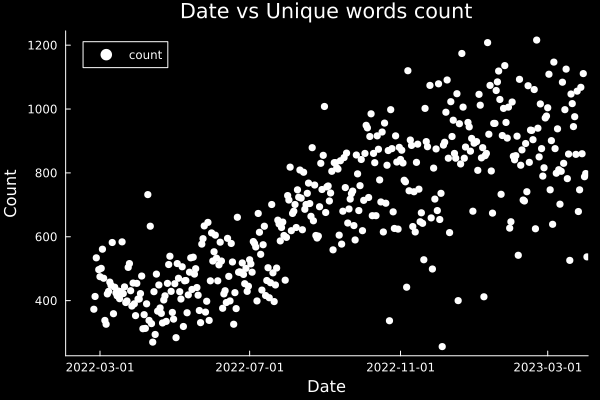

In [22]:
tfidf = DataFrame(CSV.File(tfidf_csv_path))

println(size(tfidf))
println(names(tfidf))
println(describe(tfidf))

using JSON
tfidf_keywords = tfidf[!, :Keywords]
tfidf_keywords = [JSON.parse(replace(tfidf_keywords[i], "'" => "\""), dicttype=Dict{String,Float64}) for i in 1:length(tfidf_keywords)]

# append tfidf with :Count column which will contain number of items in :Keywords
tfidf[!, :Count] = [length(tfidf_keywords[i]) for i in 1:length(tfidf_keywords)]

# tfidf_keywords_count = Dict{String,Int64}()
# for i in 1:length(tfidf_keywords)
#     for (k, v) in tfidf_keywords[i]
#         if haskey(tfidf_keywords_count, k)
#             tfidf_keywords_count[k] += 1
#         else
#             tfidf_keywords_count[k] = 1
#         end
#     end
# end
# tfidf_keywords_count


# show :Name to count of :Keywords like "assessment-2022-02-24" - 4343 where 4343 is a count of items in :Keywords

sort!(tfidf, [:Count], rev=true)
# show :Name :Date and :Count columns
tfidf[!, [:Name, :Date, :Count]]

# visualize :Date and :Count using StatsPlots with x - :Date and y - :Count
using Plots
gr()
# set limit to historgram

start_date = Date.("2022-02-01", "yyyy-mm-dd")
end_date = Date.(Dates.now())
p = plot(tfidf[!, :Date], tfidf[!, :Count], seriestype=:scatter, xlabel="Date", ylabel="Count", 
        xlims=Dates.value.([start_date, end_date]), title="Date vs Unique words count",
        legend=true, label="count", color="white", background_color="black", 
        grid=false);

# savefig(p, "plot.png")
p



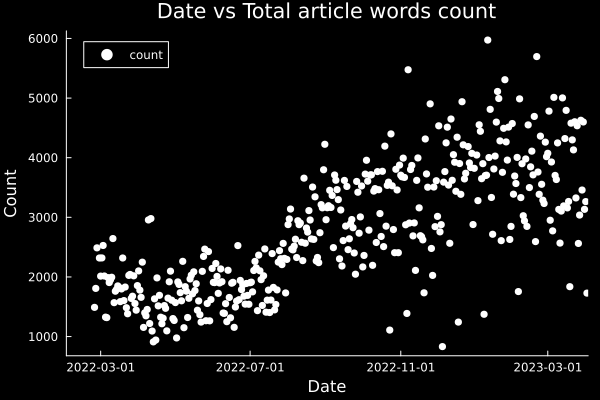

In [35]:
# read .txt file in folder ../0_data_scrapping/results/isw/* with many subfolders. Count number of words per file and save it to dataframe
df = DataFrame()
# read .txt file in folder ../0_data_scrapping/results/isw/* with many subfolders
for (root, dirs, files) in walkdir("../0_data_scrapping/results/isw/")
    for file in files
        if endswith(file, ".txt")
            file_path = joinpath(root, file)
            file_content = read(file_path, String)
            words_count = length(split(file_content))
            date = replace(file, "assessment-" => "")
            date = replace(date, ".txt" => "")
            date = Date.(date, "yyyy-mm-dd")
            df = vcat(df, DataFrame(Date=date, Count=words_count))
        end
    end
end

# sort df by :Count
sort!(df, :Count, rev=true)
df

# show inforgraphics for this dataframe
describe(df)

# visualize df with :Date and :Count
using Plots
start_date = Date.("2022-02-01", "yyyy-mm-dd")
end_date = Date.(Dates.now())
p = plot(df[!, :Date], df[!, :Count], seriestype=:scatter, xlabel="Date", ylabel="Count", 
        xlims=Dates.value.([start_date, end_date]), title="Date vs Total article words count",
        legend=true, label="count", color="white", background_color="black", 
        grid=false);
p